In [ ]:
import io
import json
import logging
import sys
import zipfile

import folium
import geopandas as gpd
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import openrouteservice
import pandas as pd
import requests
import shapely.geometry
from shapely.geometry import MultiPolygon, Point, Polygon, shape
from tqdm.notebook import tqdm

from modules import download_bpe, download_carreaus, test

# Configure logging: set level, format, and output file (if desired)
logging.basicConfig(
    level=logging.DEBUG,  # Capture all levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
    format='%(asctime)s [%(levelname)s] %(message)s',  # Log format with timestamp and level
    datefmt='%Y-%m-%d %H:%M:%S'
)



In [226]:
test()

OK


In [257]:
# Définir l'URL de base de votre instance locale d'ORS
ORS_URL = "http://localhost:8082/ors/isochrones/"
    

# Chargement et traitement des données
logging.info('Downloading Stuff')
# df_bpe = download_bpe()
df_bpe = pd.read_csv(r'data\insee\bpe_unique_Martinique_Reunion.csv')
carreaus = download_carreaus(epsg=5794)
logging.info('Download Done')


# profile = "foot-walking"
# geography = "Martinique"
# range_val = 300
# interval_val = 300


# # Convert range and interval to integer values
# try:
#     range_val = int(range_val)
#     interval_val = int(interval_val)
# except Exception as e:
#     print("Error: Range and interval must be numeric." ,{e})
#     exit()

# # --- Initialize the ORS client for your local instance ---
# client = openrouteservice.Client(base_url='http://localhost:8082/ors')

# # --- Build an output file name that reflects the parameters ---
# output_file = f"out/results_{profile}_{geography}_{range_val}_{interval_val}.jsonl"
# print(f"Results will be saved in: {output_file}")

# # --- Process each row of the 'carreaus' DataFrame ---
# with open(output_file, "w") as f_out:
#     for idx, row in tqdm(carreaus.iterrows(), total=len(carreaus), desc="Processing points"):
#         # Retrieve coordinates from DataFrame.
#         # (Make sure your DataFrame has 'longitude' and 'latitude' columns.)
#         lat, lon = row["longitude"], row["latitude"]
#         try:
#             # Request an isochrone using the user-specified parameters.
#             response = client.isochrones(
#                 locations=[[round(lon, 6), round(lat, 6)]],
#                 profile=profile,
#                 range=[range_val],
#                 interval=interval_val
#             )

#             response['Idcar_200m'] = row['Idcar_200m']
#             # Write the JSON response as a single line.
#             f_out.write(json.dumps(response) + "\n")
#         except Exception as e:
#             print(f"Error for row {idx} with coordinates ({lon}, {lat}): {e}")



2025-03-02 17:44:59 - INFO - Downloading Stuff
2025-03-02 17:45:00 - INFO - Download Done


In [258]:
profiles = ["driving-car",'cycling-regular','foot-walking']

data = []
for profile in profiles:
    with open(rf"out\results_{profile}_Martinique_300_300.jsonl", "r") as f:
        for line in f:
            data.append(json.loads(line))

    df = pd.DataFrame(data)

    features = pd.json_normalize(df['features']).rename(columns={0:'features'})

    features_normalize = pd.json_normalize(features['features'])

    # Clean up column names (if needed)
    features_normalize.columns = features_normalize.columns.str.strip()

    # Convert each row into a Shapely geometry.
    # If the "geometry.type" column is missing, you can default to a type (e.g., "Polygon")
    features_normalize['geometry'] = features_normalize.apply(
        lambda row: shape({
            'type': row.get('geometry.type', 'Polygon'),  # Use 'Polygon' as default if missing
            'coordinates': row['geometry.coordinates']
        }),
        axis=1
    )

    # Create a GeoDataFrame from your DataFrame using the new 'geometry' column.
    isochrone_gdf = gpd.GeoDataFrame(features_normalize, crs="EPSG:5794", geometry='geometry')

    isochrone_gdf['Idcar_200m'] = df['Idcar_200m']

    # Assuming your DataFrame 'df_bpe' has columns 'longitude' and 'latitude'
    isochrone_gdf = gpd.GeoDataFrame(
        df_bpe,
        geometry=gpd.points_from_xy(df_bpe.LONGITUDE, df_bpe.LATITUDE),
        crs="EPSG:5794"  # You can change the CRS if needed
    )

    # Assuming your DataFrame 'df_bpe' has columns 'longitude' and 'latitude'
    gdf_bpe = gpd.GeoDataFrame(
        df_bpe,
        geometry=gpd.points_from_xy(df_bpe.LONGITUDE, df_bpe.LATITUDE),
        crs="EPSG:5794"  # You can change the CRS if needed
    )

    joined = gdf_bpe.sjoin(isochrone_gdf, how="inner")



Carreaus bounds after swapping: [ 14.39619677 -61.22887659  14.87928948 -60.81969049]


c:\Users\selaazdo-24\.conda\envs\fecolab\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\selaazdo-24\.conda\envs\fecolab\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


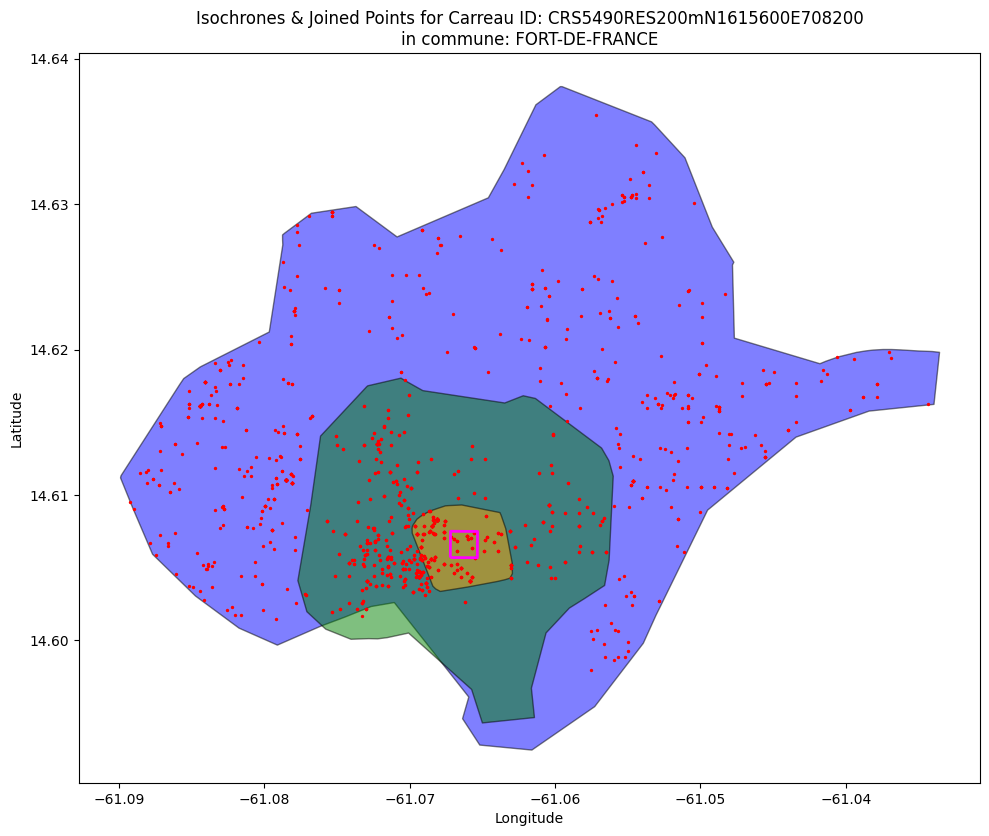

In [260]:

# -------------------------------------------------------------------
# 0. Function: Test CRS and Bounds
# -------------------------------------------------------------------
def test_crs_and_bounds(carreaus, isochrone_gdf, gdf_bpe):
    """
    Prints the CRS and total bounds for each GeoDataFrame.
    Checks if all CRS match and raises a warning if not.
    """
    print("=== CRS ===")
    print("Carreaus CRS:      ", carreaus.crs)
    print("Isochrone CRS:     ", isochrone_gdf.crs)
    print("Points (BPE) CRS:  ", gdf_bpe.crs)
    print()
    print("=== Bounding Boxes ===")
    print("Carreaus bounds:      ", carreaus.total_bounds)
    print("Isochrone bounds:     ", isochrone_gdf.total_bounds)
    print("Points (BPE) bounds:  ", gdf_bpe.total_bounds)
    print()
    all_crs = [carreaus.crs, isochrone_gdf.crs, gdf_bpe.crs]
    if len(set(all_crs)) != 1:
        print("WARNING: Not all CRS match or one is None. Ensure they are consistent!")
    else:
        print("All CRS match. Good to go!")

# -------------------------------------------------------------------
# 1. Swap Coordinates in Carreaus (if necessary)
# -------------------------------------------------------------------
def swap_xy(geom):
    """Swap x and y coordinates of a shapely geometry."""
    if geom.is_empty:
        return geom
    if geom.geom_type == 'Point':
        return shapely.geometry.Point(geom.y, geom.x)
    elif geom.geom_type == 'Polygon':
        new_exterior = [(y, x) for x, y in geom.exterior.coords]
        new_interiors = []
        for interior in geom.interiors:
            new_interiors.append([(y, x) for x, y in interior.coords])
        return shapely.geometry.Polygon(new_exterior, new_interiors)
    elif geom.geom_type == 'MultiPolygon':
        return shapely.geometry.MultiPolygon([swap_xy(poly) for poly in geom.geoms])
    else:
        return geom

# Apply the coordinate swap to all geometries in 'carreaus'
carreaus['geometry'] = carreaus['geometry'].apply(swap_xy)
carreaus = carreaus.set_crs("EPSG:5794", allow_override=True)
carreaus = carreaus.to_crs("EPSG:5794")
print("Carreaus bounds after swapping:", carreaus.total_bounds)

# -------------------------------------------------------------------
# 2. Load Isochrone Data & Create GeoDataFrame
# -------------------------------------------------------------------
profiles = ["driving-car", "cycling-regular", "foot-walking"]
data = []
for profile in profiles:
    file_path = rf"out\results_{profile}_Martinique_300_300.jsonl"
    with open(file_path, "r") as f:
        for line in f:
            record = json.loads(line)
            record['profile'] = profile
            data.append(record)

df = pd.DataFrame(data)
features = pd.json_normalize(df['features']).rename(columns={0: 'features'})
features_normalize = pd.json_normalize(features['features'])
features_normalize.columns = features_normalize.columns.str.strip()

features_normalize['geometry'] = features_normalize.apply(
    lambda row: shape({
        'type': row.get('geometry.type', 'Polygon'),
        'coordinates': row['geometry.coordinates']
    }),
    axis=1
)

isochrone_gdf = gpd.GeoDataFrame(features_normalize, crs="EPSG:5794", geometry='geometry')
isochrone_gdf['Idcar_200m'] = df['Idcar_200m']
isochrone_gdf['profile'] = df['profile']

# -------------------------------------------------------------------
# 3. Filter for Target Carreau
# -------------------------------------------------------------------
target_id = 'CRS5490RES200mN1615600E708200'
filtered_isochrones = {}
for profile in profiles:
    filtered_isochrones[profile] = isochrone_gdf[
        (isochrone_gdf['Idcar_200m'] == target_id) &
        (isochrone_gdf['profile'] == profile)
    ]

# -------------------------------------------------------------------
# 4. Load / Prepare Points Data
# -------------------------------------------------------------------
gdf_bpe = gpd.GeoDataFrame(
    df_bpe,
    geometry=gpd.points_from_xy(df_bpe.LONGITUDE, df_bpe.LATITUDE),
    crs="EPSG:5794"
)
gdf_bpe_test = gdf_bpe.loc[gdf_bpe['REG'] == 2]

all_isochrones = pd.concat(filtered_isochrones.values(), ignore_index=True)
joined = gpd.sjoin(gdf_bpe_test, all_isochrones, how="inner", predicate='intersects').drop(columns=['index_right'])
target_commune = joined[joined['Idcar_200m'] == target_id].iloc[0]['LIBCOM']

# -------------------------------------------------------------------
# 5. Plot Everything: Isochrones, Points, and Carreau Boundaries
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each isochrone with its designated color
profile_colors = {
    "driving-car": "blue",
    "cycling-regular": "green",
    "foot-walking": "orange"
}
for profile, color in profile_colors.items():
    iso = filtered_isochrones[profile]
    if not iso.empty:
        iso.plot(ax=ax, color=color, edgecolor='black', alpha=0.5)

# Plot the joined points in red
joined.plot(ax=ax, color='red', markersize=2)

def swap_xy_target(geom):
    """Swap the x and y coordinates of a polygon or multipolygon geometry."""
    if geom.is_empty:
        return geom
    if geom.geom_type == 'Polygon':
        new_exterior = [(y, x) for x, y in geom.exterior.coords]
        new_interiors = [
            [(y, x) for x, y in interior.coords] for interior in geom.interiors
        ]
        return shapely.geometry.Polygon(new_exterior, new_interiors)
    elif geom.geom_type == 'MultiPolygon':
        return shapely.geometry.MultiPolygon([swap_xy_target(poly) for poly in geom.geoms])
    else:
        return geom

target_geom = carreaus.loc[carreaus['Idcar_200m'] == target_id]

# Swap columns for target geometry
target_geom['longitude'], target_geom['latitude'] = target_geom['latitude'], target_geom['longitude']
target_geom['geometry'] = target_geom['geometry'].apply(swap_xy_target)

# Plot the target carreau boundary in magenta (no fill)
target_geom.boundary.plot(ax=ax, color='magenta', linewidth=2)

# -------------------------------------------------------------------
# 6. Build Separate Legends (Like Before)
# -------------------------------------------------------------------
driving_patch = mpatches.Patch(facecolor='blue', edgecolor='black', label='driving-car')
cycling_patch = mpatches.Patch(facecolor='green', edgecolor='black', label='cycling-regular')
walking_patch = mpatches.Patch(facecolor='orange', edgecolor='black', label='foot-walking')
boundary_patch = mpatches.Patch(facecolor='none', edgecolor='magenta', label='Carreau boundary')

points_patch = mlines.Line2D([], [], color='red', marker='o', linestyle='None', 
                             markersize=5, label='Joined Points')

iso_legend = ax.legend(handles=[driving_patch, cycling_patch, walking_patch, boundary_patch],
                       title='Isochrones',
                       loc='upper left',
                       bbox_to_anchor=(1.02, 1))
ax.add_artist(iso_legend)

points_legend = ax.legend(handles=[points_patch],
                          title='Amenities',
                          loc='upper left',
                          bbox_to_anchor=(1.02, 0.7))
ax.add_artist(points_legend)

# -------------------------------------------------------------------
# 7. Final Plot Settings
# -------------------------------------------------------------------
plt.title(f"Isochrones & Joined Points for Carreau ID: {target_id}\n"
          f"in commune: {target_commune}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# <<< ADDED LINE TO LEAVE SPACE ON THE RIGHT FOR LEGENDS >>>
fig.subplots_adjust(right=0.75)

plt.tight_layout()
plt.show()


In [261]:
fig.savefig('out/graphs/isochrones.png')

In [ ]:
joined.groupby('Idcar_200m').agg(
    {'ID':'count'}
).sort_values(by='ID')

,ID
Idcar_200m,
CRS5490RES200mN1615600E708200,1567
